In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter

import catboost
from catboost import CatBoostClassifier
import lightgbm as lgb
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

# Reading Data

In [2]:
path = '/home/ricardo/TCC/'

In [3]:
df = pd.read_csv(path+'train.csv', sep = ',')
X = df.loc[:,'var_0':'var_199']
Y = df.loc[:,'target']

# Normalizing Data

In [4]:
meanX = X.mean(axis = 0)
stdX = X.std(axis = 0)
X_norm = (X-meanX)/stdX

# Separating the Data in anomaly and not anomaly

In [5]:
fraud_index = np.where(Y==1)
honest_index = np.where(Y==0)
fraud = X_norm.loc[fraud_index]
honest = X_norm.loc[honest_index]

yh = Y.loc[honest_index]
yf = Y.loc[fraud_index]

# Balanced Data

### Verifying how unbalanced is our dataset

Text(0.5, 1.0, '8.951238929246692')

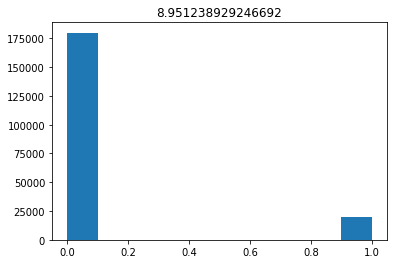

In [6]:
plt.hist(Y)
plt.title(len(yh)/len(yf))

### To balance the data we will eliminate some not anomaly samples

In [7]:
h_used, x_trash, yh, y_trash = train_test_split(honest, yh, test_size = 0.75, random_state = 30)
x_used = pd.concat([h_used,fraud],ignore_index = False)
y_used = pd.concat([yh,yf],ignore_index=False)

### Verifying if it is balanced now

Text(0.5, 1.0, '2.2377848542143495')

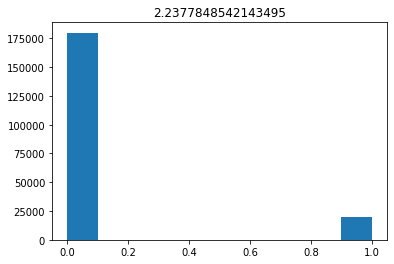

In [8]:
plt.hist(Y)
plt.title(len(yh)/len(yf))

# Separating in Train, Val and Test data

In [9]:
x_train,x_test,y_train,y_test = train_test_split(x_used,y_used,test_size=0.3,random_state = 30)
x_val,x_test,y_val,y_test = train_test_split(x_test,y_test,test_size=0.5,random_state = 30)

In [10]:
x_data = [x_train,x_val,x_test]
y_data = [y_train,y_val,y_test]

### Verifying the size of each dataframe

In [11]:
print('Resampled dataset shape %s' % Counter(y_train))
print('Resampled dataset shape %s' % Counter(y_test))
print('Resampled dataset shape %s' % Counter(y_val))

Resampled dataset shape Counter({0: 31412, 1: 14139})
Resampled dataset shape Counter({0: 6784, 1: 2977})
Resampled dataset shape Counter({0: 6779, 1: 2982})


# Importing some metrics to evaluating the models.

In [12]:
def F1_eval(preds, dtrain):
    res = _F1_eval(preds, dtrain.get_label())
    return 'f1_err', 1-res

In [13]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [14]:
def choosing_threshold(y_true,y_prob,threshold_list):
    y_hat = []
    precision = []
    recall = []
    f1 = []
    y_h = []
    for threshold in threshold_list:
        for i in range(len(y_true)):
            if y_prob[i]>threshold:
                y_hat.append(1)
            else:
                y_hat.append(0)
        precision.append(precision_score(y_true,y_hat))
        recall.append(recall_score(y_true,y_hat))
        f1.append(f1_score(y_true,y_hat))
        y_h.append(y_hat)
        y_hat = []
    return(precision,recall,f1,y_h)                       

In [15]:
def predict_threshold(y_prob,threshold):
    y_hat = []
    for i in range(len(y_prob)):
        if y_prob[i]>threshold:
            y_hat.append(1)
        else:
            y_hat.append(0)
    return y_hat

# XGBoostClassifier

In [16]:
# model = XGBClassifier(silent=False, 
#                       scale_pos_weight=1,
#                       learning_rate=0.01,  
#                       colsample_bytree = 0.4,
#                       subsample = 0.8,
#                       objective='binary:logistic', 
#                       n_estimators=2000, 
#                       reg_alpha = 0.3,
#                       max_depth=4, 
#                       gamma=10)

# eval_set = [(x_data[0], y_data[0]), (x_data[1], y_data[1])]
# eval_metric = F1_eval

weights = (Y==0).sum()/(1.0 *  (Y==1).sum())
model = XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4)
model.fit(x_data[0],y_data[0])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=4,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=8.951238929246692,
              seed=None, silent=None, subsample=1, verbosity=1)

- ###  Analysing the performance with differents thresholds

precision values: [0.31039933261618846, 0.31039933261618846, 0.31039933261618846, 0.31039933261618846, 0.31039933261618846, 0.31039933261618846, 0.31039933261618846, 0.31039933261618846, 0.31039933261618846, 0.31039933261618846, 0.31039933261618846, 0.31039933261618846, 0.31039933261618846, 0.31039933261618846, 0.31039933261618846, 0.31039933261618846, 0.31039933261618846, 0.31039933261618846, 0.31039933261618846, 0.31039933261618846, 0.31039933261618846, 0.31039933261618846, 0.31039933261618846, 0.31039933261618846, 0.31039933261618846, 0.31039933261618846, 0.31039933261618846, 0.31039933261618846, 0.3104061470911087, 0.3104265923112389, 0.31044704022483754, 0.3104879441345689, 0.31055614127569847, 0.31064484235966167, 0.31078140454995057, 0.31103436138853446, 0.3113151463108528, 0.3118094608005293, 0.3124917119745392, 0.31323245973548375, 0.3142114153627312, 0.3155697445972495, 0.3173733381243263, 0.31953238060781475, 0.321960113960114, 0.32492636229749633, 0.3283304246655032, 0.3325

Normalized confusion matrix
[[0.25229212 0.74770788]
 [0.01478181 0.98521819]]
Normalized confusion matrix
[[0.28492296 0.71507704]
 [0.01845958 0.98154042]]
Normalized confusion matrix
[[0.31812683 0.68187317]
 [0.02277389 0.97722611]]
Normalized confusion matrix
[[0.35575576 0.64424424]
 [0.02864418 0.97135582]]
Normalized confusion matrix
[[0.39453075 0.60546925]
 [0.03500955 0.96499045]]
Normalized confusion matrix
[[0.4318095  0.5681905 ]
 [0.04300163 0.95699837]]
Normalized confusion matrix
[[0.47042532 0.52957468]
 [0.05304477 0.94695523]]
Normalized confusion matrix
[[0.51095123 0.48904877]
 [0.063583   0.936417  ]]
Normalized confusion matrix
[[0.55166815 0.44833185]
 [0.07687955 0.92312045]]
Normalized confusion matrix
[[0.5915892  0.4084108 ]
 [0.09441969 0.90558031]]
Normalized confusion matrix
[[0.63017318 0.36982682]
 [0.11224273 0.88775727]]
Normalized confusion matrix
[[0.66939386 0.33060614]
 [0.13197539 0.86802461]]
Normalized confusion matrix
[[0.70746848 0.29253152]

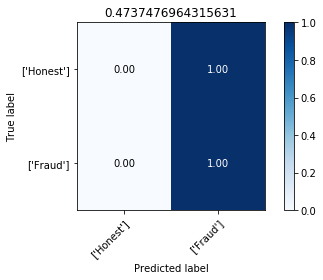

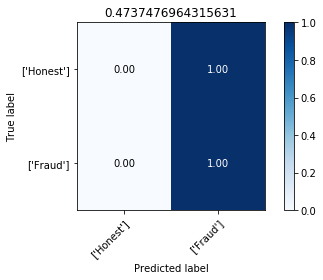

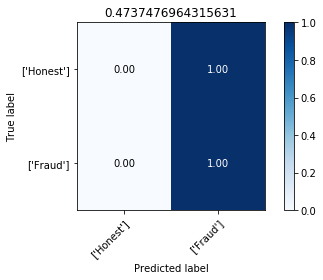

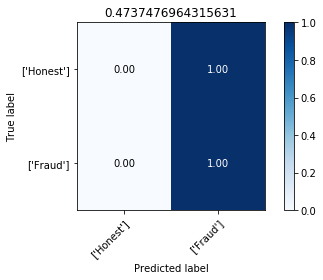

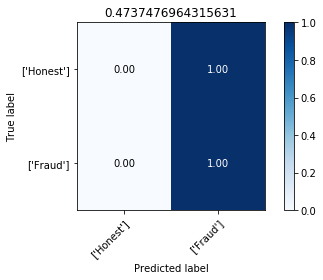

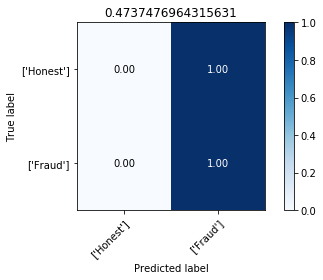

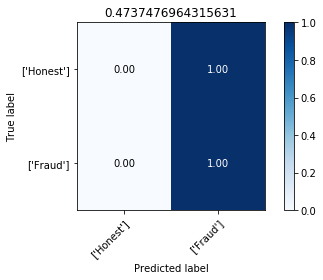

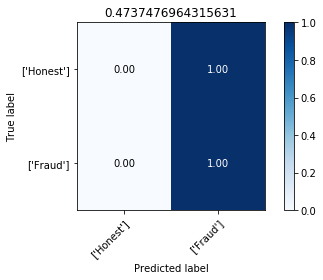

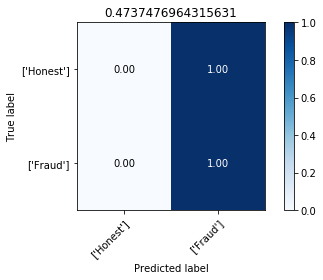

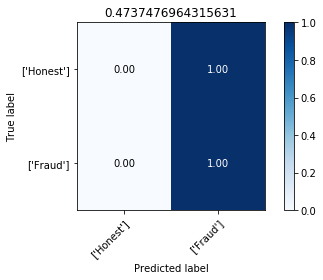

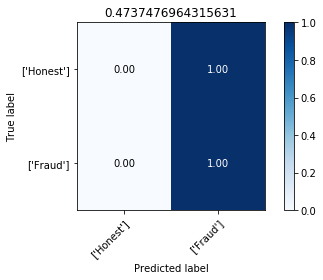

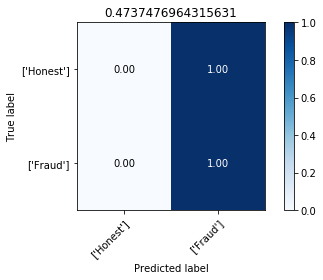

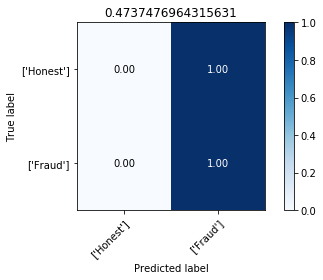

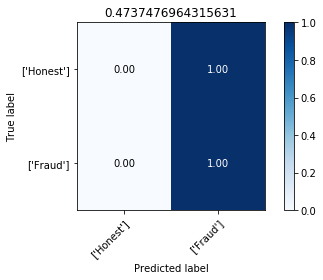

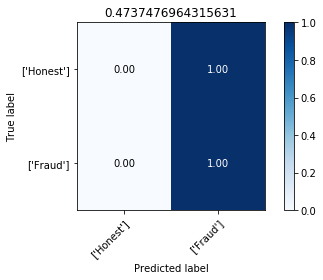

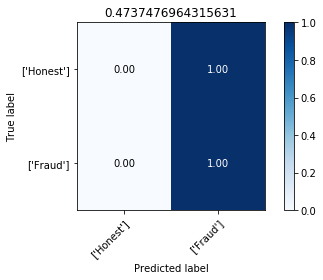

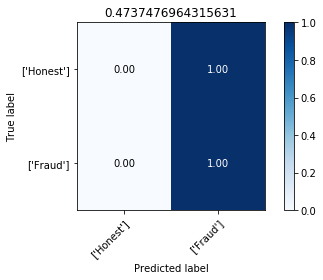

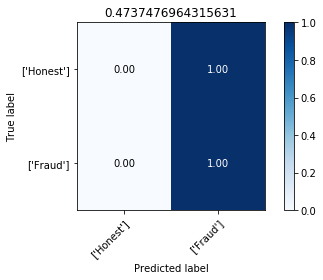

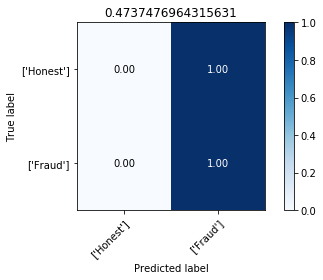

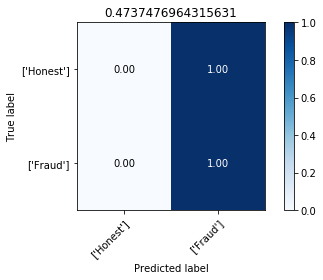

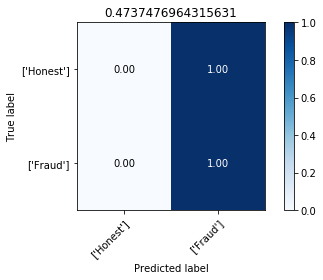

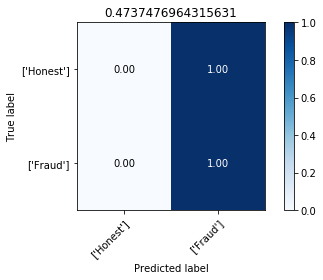

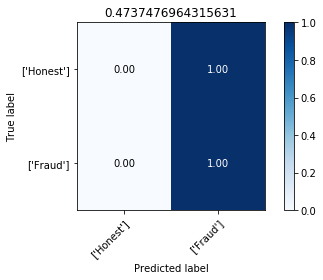

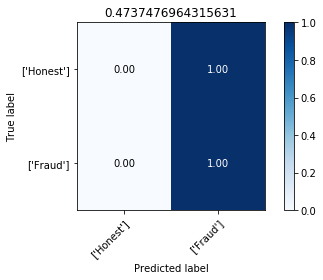

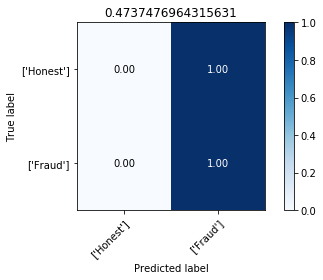

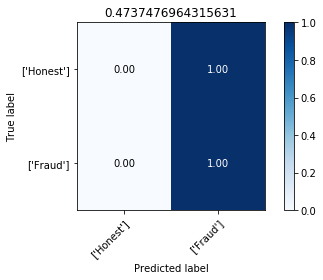

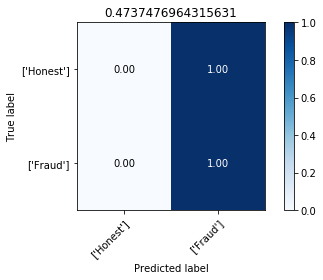

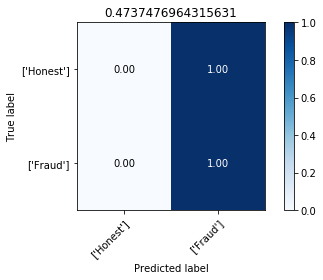

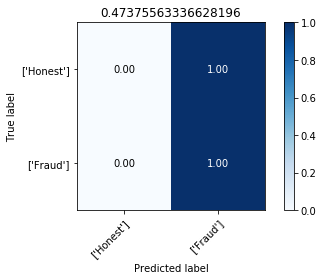

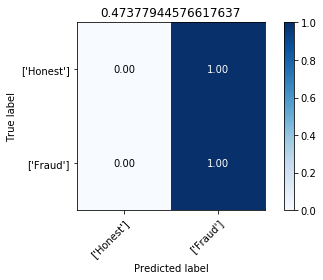

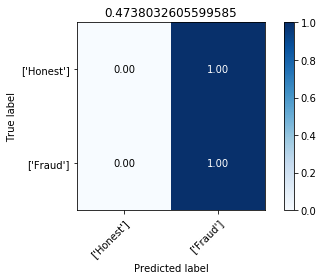

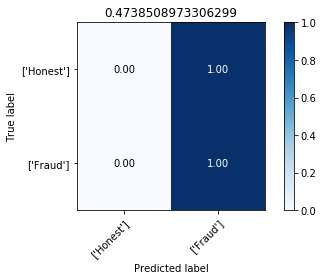

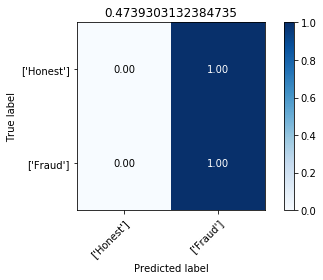

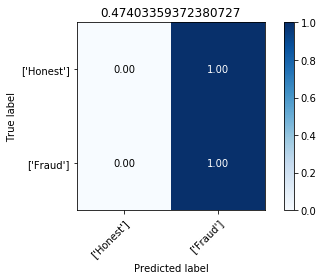

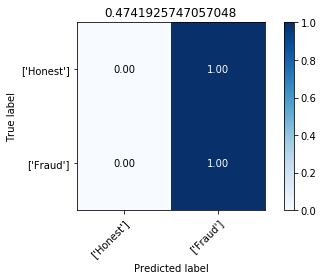

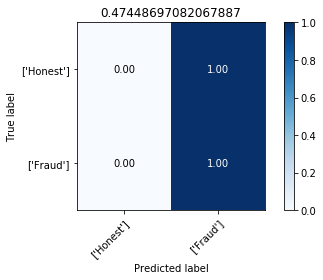

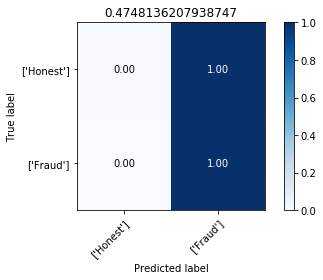

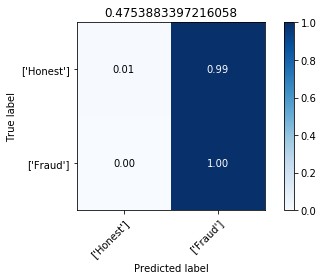

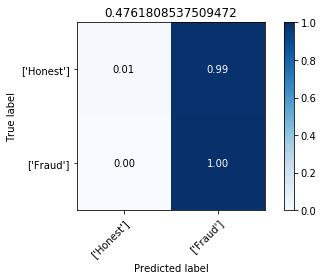

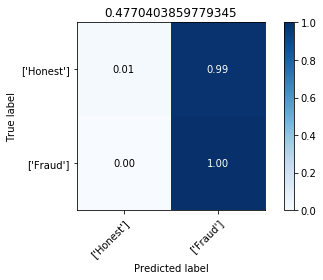

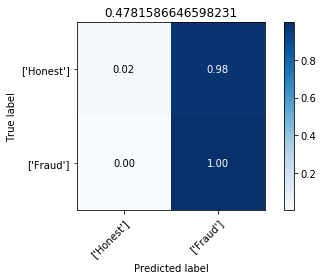

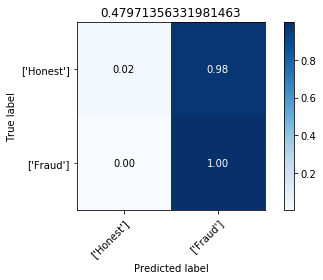

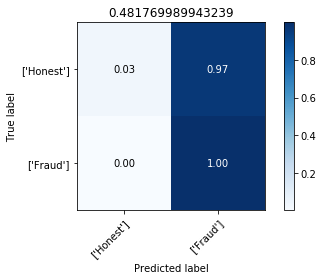

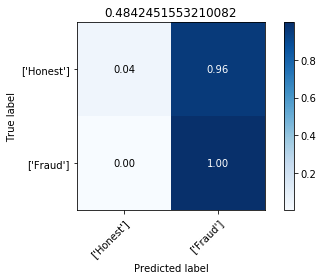

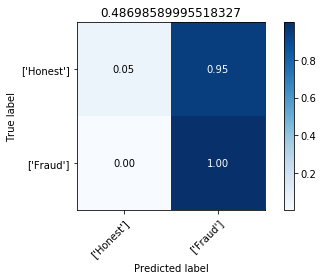

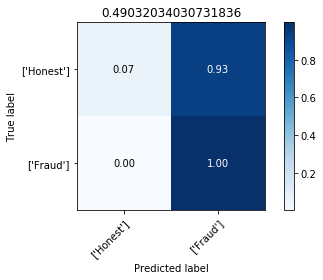

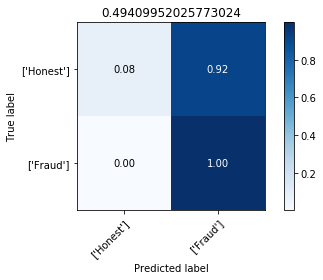

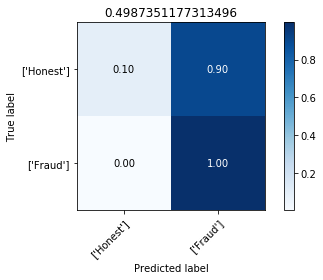

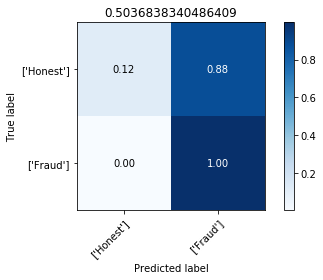

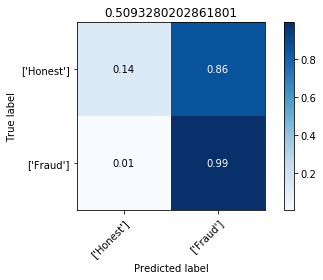

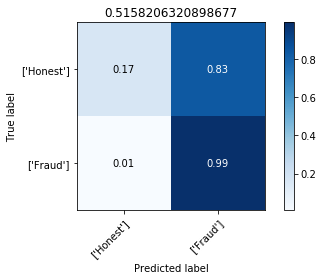

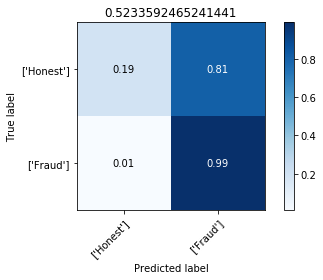

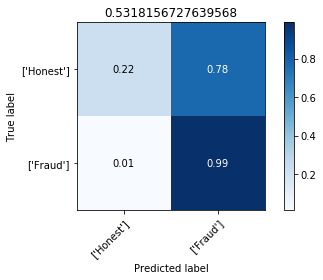

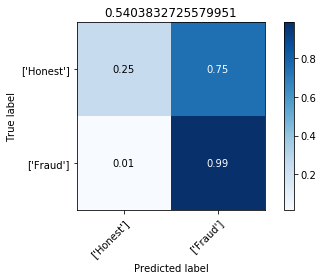

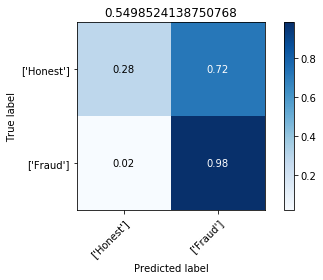

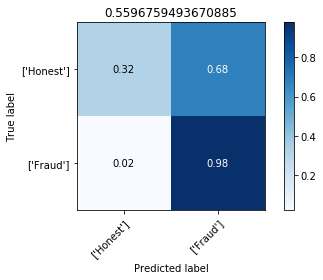

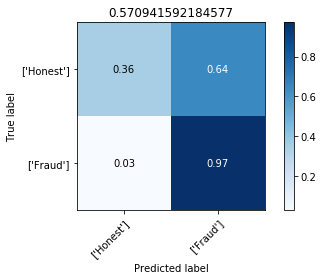

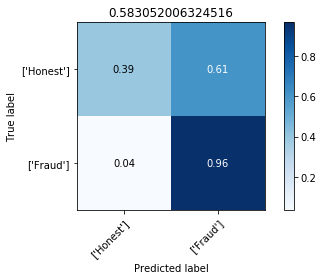

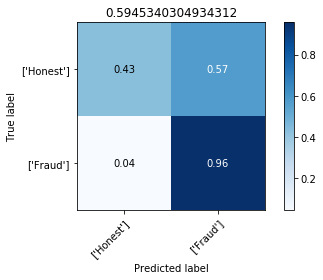

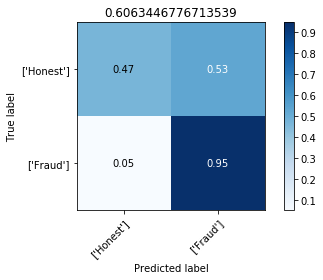

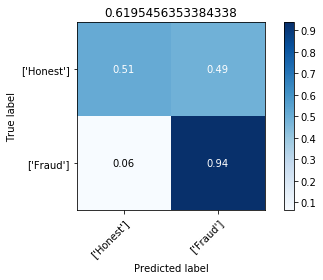

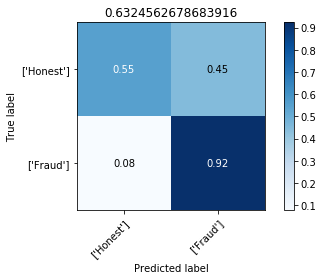

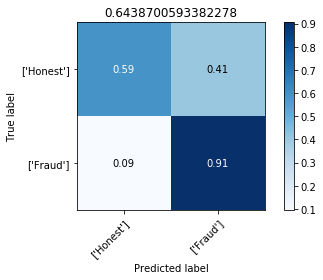

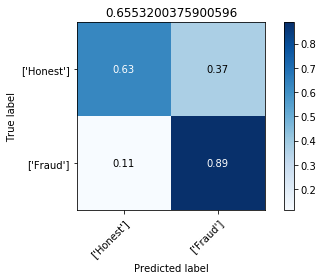

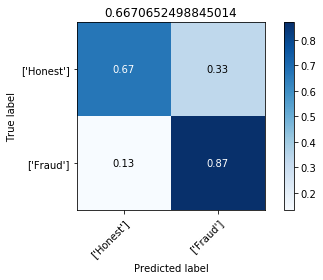

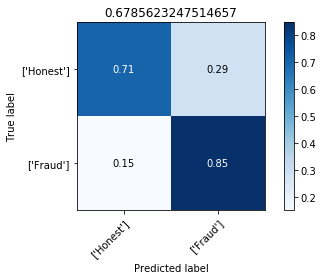

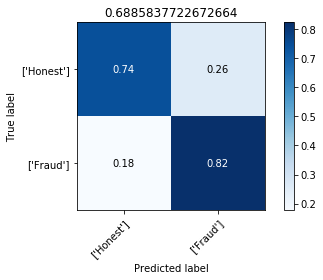

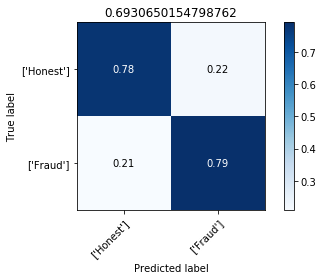

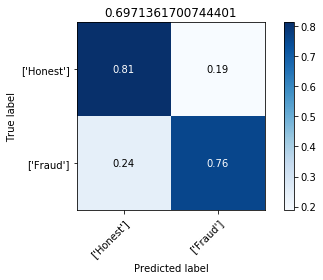

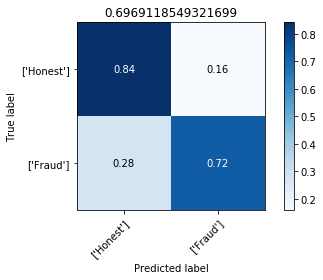

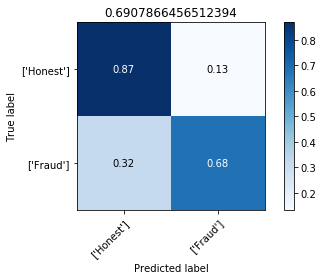

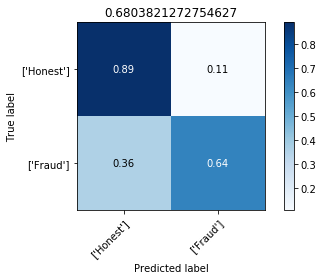

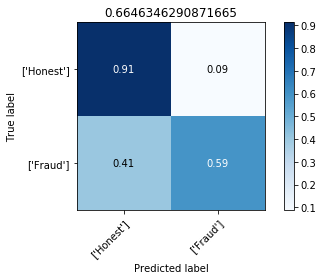

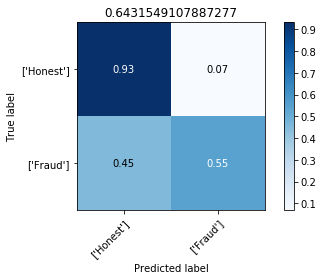

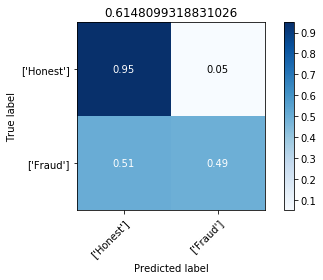

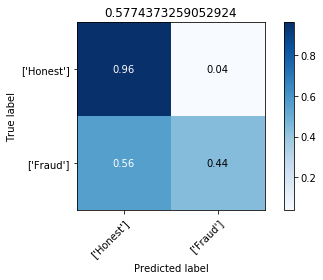

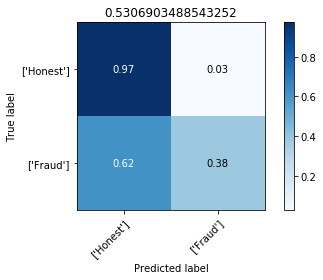

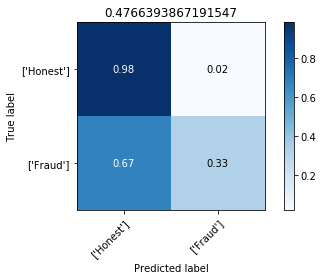

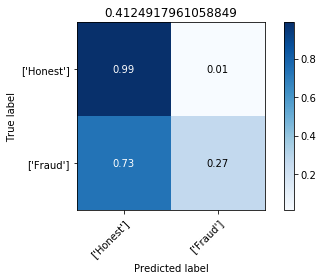

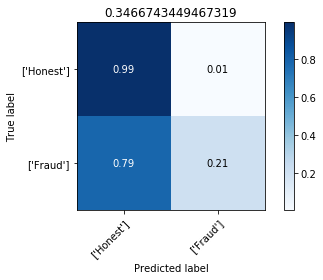

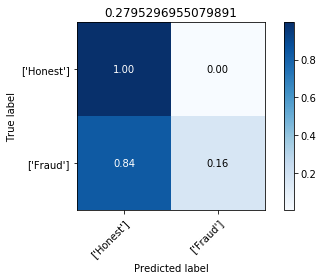

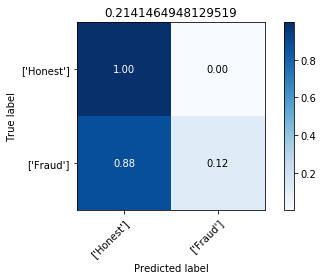

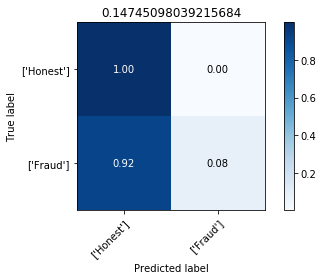

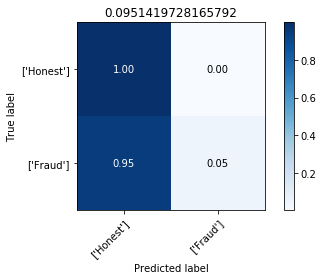

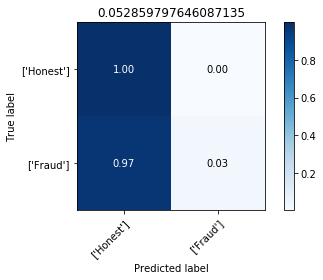

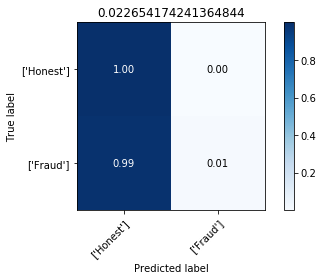

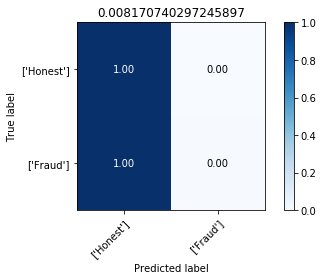

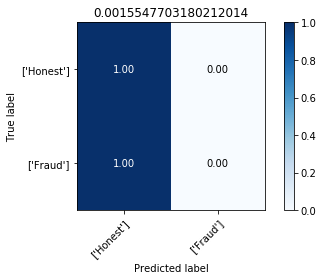

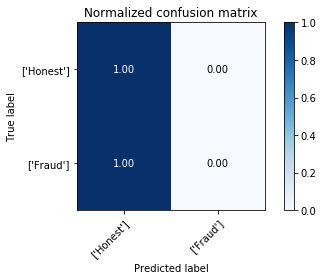

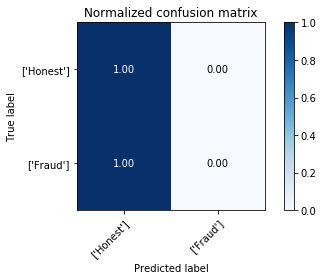

In [17]:
prob = np.ravel(model.predict_proba(x_data[0])[:,1])
threshold_list = np.arange(0.1,1,0.01)
precision,recall,f1,yprob = choosing_threshold(y_data[0],prob,threshold_list)

print('precision values: {}'.format(precision))
print('recall values: {}'.format(recall))
print('f1 values: {}'.format(f1))

for i in range(len(yprob)):
    plot_confusion_matrix(y_data[0], yprob[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)

- ### Predicting with the best Threshold

Normalized confusion matrix
[[0.81214186 0.18785814]
 [0.24160124 0.75839876]]
Normalized confusion matrix
[[0.77725328 0.22274672]
 [0.29376258 0.70623742]]
Normalized confusion matrix
[[0.78862028 0.21137972]
 [0.29593551 0.70406449]]


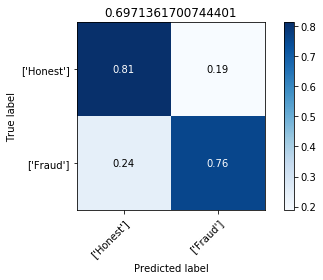

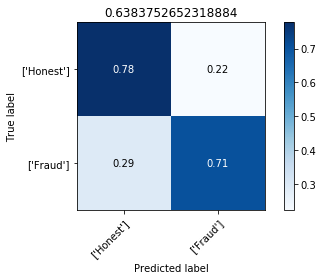

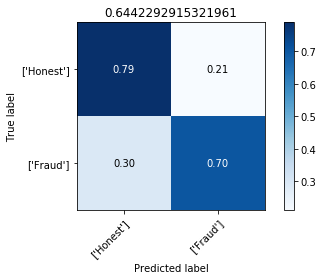

In [18]:
y_hat = []
for i in range(len(x_data)):
    y_hat.append(predict_threshold(np.ravel(model.predict_proba(x_data[i])[:,1]),
                                   threshold_list[f1.index(max(f1))]))

for i in range(len(y_hat)):
    plot_confusion_matrix(y_data[i], y_hat[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1_score(y_data[i],y_hat[i]),
                          cmap=plt.cm.Blues)

In [20]:
model.save_model(path+'/Undersampling/Boost/models/XGBoostClassifier')